<a href="https://colab.research.google.com/github/Seeun1124/myrepo/blob/main/%EB%A6%AC%EB%AA%A8%ED%8A%B8%EC%9D%B8%ED%84%B4%EC%8B%AD_%EB%B6%84%EC%84%9D%EC%82%B0%EC%B6%9C%EB%AC%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **필요한 데이터**

1. 동별 인구수 데이터 (https://kosis.kr/statHtml/statHtml.do?orgId=711&tblId=DT_YB2001&vw_cd=MT_ZTITLE&list_id=214A_711_71104_002_002&scrId=&seqNo=&lang_mode=ko&obj_var_id=&itm_id=&conn_path=MT_ZTITLE&path=%252FstatisticsList%252FstatisticsListIndex.do)
2. 버스정류장 데이터 (https://www.data.go.kr/data/15080859/fileData.do)
3. 전주시 POI 데이터 (https://bigdata-geo.kr/user/dataset/view.do?data_sn=12)
4. 자전거 보관소 데이터 (https://www.data.go.kr/data/15012184/openapi.do)
5. 공영주차장 데이터 (https://www.data.go.kr/data/15003201/fileData.do)
6. 자전거 대여소 데이터 (https://jeonju.go.kr/data/main/content.action?cmsid=101040200000)
7. 동별 면적 데이터(https://kosis.kr/statHtml/statHtml.do?orgId=214&)






# 패키지 import

In [ ]:
import pandas as pd
import numpy as np
import folium
import json
import requests
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 처리

In [ ]:
# 한글 폰트가 깨질 때 사용 - 런타임 메뉴에서 다시 시작 및 모두 실행 선택.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
# 그림 그리기를 위한 코드와 한글 실행
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

plt.rc('font', family='NanumBarunGothic') # clolab 에서 한글 사용
plt.rcParams['axes.unicode_minus'] = False

# 전주시 동별 인구

## 전처리

In [ ]:
# 전주시 구동별 인구 csv파일 불러오기
pop = pd.read_csv('/content/전주시_구동별_인구.csv')

# 맨 앞의 필요없는 행 2개 제거 후 열 이름 변경
pop = pop.loc[2:].set_axis(['구','동','세대수','총인구'], axis=1).reset_index(drop = True)

# 그래프로 시각화하기 위해 type을 float형으로 변환
pop['세대수'] = pop['세대수'].astype(float)
pop['총인구'] = pop['총인구'].astype(float)

# 소계가 포함된 행 제거
pop2 = pop[pop['동']!='소계'].reset_index(drop = True)

## 시각화

### GeoDataFrame 전처리

In [ ]:
gjson = gpd.read_file('/content/hangjeongdong_전라북도.geojson')# GeoJSON 파일 읽기
dong_geo = gjson[gjson['sggnm'].isin(['전주시완산구', '전주시덕진구'])].reset_index(drop = True) # 전주시에 해당하는 행만 추출

# 'add_nm'열에서 행정동 이름만 나타내기
dong_geo['adm_nm'] = [dong_geo['adm_nm'][i].split('구 ')[1] for i in range(len(dong_geo))]

### 시각화

In [ ]:
import os
import plotly.express as px

In [ ]:
boundary = dong_geo[['adm_nm', 'geometry']].set_index('adm_nm')

In [ ]:
boundary.to_file('_dong_geo.json', driver='GeoJSON')

In [ ]:
with open('_dong_geo.json', 'r') as file:
    dong_json = json.load(file)

In [ ]:
pop_vs = pop2.rename({'동':'adm_nm'}, axis=1)

In [ ]:
fig = px.choropleth(data_frame = pop_vs,
                    geojson=dong_json,
                    locations='adm_nm',
                    color='총인구',
                    color_continuous_scale='Blues',
                    center={"lat": 35.84195368311022, "lon": 127.1155556693179}, # 중심을 전주로 설정
                    featureidkey='properties.adm_nm')

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text='동별 인구 수', title_font_size=20)

# 전주시 버스정류장

In [ ]:
bus_df = pd.read_csv('/content/버스정류장.csv')
bus_df.columns = ['ID', 'NAME', 'NUMBER','LAT','LONG']
bus_df

,ID,NAME,NUMBER,LAT,LONG
0,JUB312100690,BYC,30690,35.820431,127.007781
1,JUB312100693,BYC,30693,35.820713,127.007970
2,JUB306101433,cbs기독교방송,31432,35.874691,127.055197
3,JUB305100683,CTS전북방송,30683,35.819997,127.146407
4,JUB305032322,JTV전주방송,36214,35.845972,127.082964
...,...,...,...,...,...
2789,JUB305100431,흑석대승푸른맨션,30431,35.799576,127.150543
2790,JUB305100460,흑석송원아파트,30460,35.801901,127.150376
2791,JUB305100463,흑석송원아파트,30463,35.802335,127.150055
2792,JUB306100817,흥국생명,30817,35.828120,127.141920


## 데이터 전처리

In [ ]:
# 버스정류장 데이터의 위도와 경도를 Point 객체로 변환
bus_df['geometry'] = bus_df.apply(lambda row: Point(row['LONG'], row['LAT']), axis=1)

# GeoDataFrame으로 변환
bus_df = gpd.GeoDataFrame(bus_df, geometry='geometry')

# 버스정류장 데이터와 행정동 경계 데이터의 공간 연산
bus_with_dong = gpd.sjoin(bus_df, dong_geo, how='left', op='within')
bus_with_dong

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

<ipython-input-13-b8fee0666749>:8: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326




,ID,NAME,NUMBER,LAT,LONG,geometry,index_right,OBJECTID,adm_nm,adm_cd,adm_cd2,sgg,sido,sidonm,sggnm
0,JUB312100690,BYC,30690,35.820431,127.007781,POINT (127.00778 35.82043),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JUB312100693,BYC,30693,35.820713,127.007970,POINT (127.00797 35.82071),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JUB306101433,cbs기독교방송,31432,35.874691,127.055197,POINT (127.05520 35.87469),30.0,2251.0,조촌동,3501267,4511365000,45113,45,전라북도,전주시덕진구
3,JUB305100683,CTS전북방송,30683,35.819997,127.146407,POINT (127.14641 35.82000),15.0,2236.0,풍남동,3501175,4511153000,45111,45,전라북도,전주시완산구
4,JUB305032322,JTV전주방송,36214,35.845972,127.082964,POINT (127.08296 35.84597),31.0,2252.0,여의동,3501271,4511366500,45113,45,전라북도,전주시덕진구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,JUB305100431,흑석대승푸른맨션,30431,35.799576,127.150543,POINT (127.15054 35.79958),1.0,2222.0,서서학동,3501161,4511166000,45111,45,전라북도,전주시완산구
2790,JUB305100460,흑석송원아파트,30460,35.801901,127.150376,POINT (127.15038 35.80190),1.0,2222.0,서서학동,3501161,4511166000,45111,45,전라북도,전주시완산구
2791,JUB305100463,흑석송원아파트,30463,35.802335,127.150055,POINT (127.15006 35.80233),1.0,2222.0,서서학동,3501161,4511166000,45111,45,전라북도,전주시완산구
2792,JUB306100817,흥국생명,30817,35.828120,127.141920,POINT (127.14192 35.82812),32.0,2253.0,진북동,3501269,4511352500,45113,45,전라북도,전주시덕진구


In [ ]:
bus_with_dong.isnull().sum() # 결측치 확인

ID                0
NAME              0
NUMBER            0
LAT               0
LONG              0
geometry          0
index_right    1456
OBJECTID       1456
adm_nm         1456
adm_cd         1456
adm_cd2        1456
sgg            1456
sido           1456
sidonm         1456
sggnm          1456
dtype: int64

In [ ]:
# 동별 버스정류장 개수 계산
bus_count = bus_with_dong.adm_nm.value_counts();bus_count

여의동      137
조촌동      122
삼천3동      97
송천2동      81
효자4동      68
평화2동      66
동서학동      63
효자5동      58
우아2동      53
덕진동       52
호성동       47
송천1동      42
서신동       41
팔복동       40
인후3동      30
진북동       29
풍남동       25
중앙동       25
인후2동      23
노송동       22
혁신동       21
중화산2동     21
우아1동      20
서서학동      20
금암1동      20
인후1동      18
금암2동      18
효자2동      15
삼천2동      14
삼천1동      12
중화산1동     11
효자3동       8
평화1동       7
완산동        6
효자1동       6
Name: adm_nm, dtype: int64

## 시각화

In [ ]:
bus_vs = bus_count.to_frame().reset_index().set_axis(['adm_nm', 'value'], axis=1)

In [ ]:
# Choropleth 시각화
fig = px.choropleth(data_frame = bus_vs,
                    geojson=dong_json,
                    locations='adm_nm',
                    color='value',
                    color_continuous_scale='Blues',
                    center={"lat": 35.84195368311022, "lon": 127.1155556693179}, # 중심을 전주로 설정
                    featureidkey='properties.adm_nm',
                    )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text='동별 버스정류장 개수', title_font_size=20)

# 전주시 동별 poi

## 데이터 전처리

In [ ]:
poi_df = pd.read_csv('/content/전주_POI.csv',encoding='cp949',engine='python')
poi_df.head()

,ID,XPOS,YPOS,NAME,FMCODE,KIND1,KIND2,KIND3,WKT
0,117074,127.127140,35.770270,신봉,14,지명관련,자연부락,NaN,POINT Z (127.12714002810014 35.77026967670488 ...
1,117077,127.138989,35.761662,금성산,18,지명관련,산/산맥,NaN,POINT Z (127.13898905340014 35.76166238280495 ...
2,117213,127.142864,35.766062,덕천사,70102,문화/종교/예술,종교시설,절,POINT Z (127.14286367470015 35.76606190640491 ...
3,117225,127.123240,35.755821,삼천천,38,지명관련,하천,NaN,POINT Z (127.12324049230017 35.75582129020502 ...
4,117286,127.157287,35.800691,전주남고산성,80300,관광/숙박,성,NaN,POINT Z (127.15728711220017 35.80069140040455 ...


In [ ]:
# 상가 데이터의 위도와 경도를 Point 객체로 변환
poi_df['geometry'] = poi_df.apply(lambda row: Point(row['XPOS'], row['YPOS']), axis=1)

# GeoDataFrame으로 변환
poi_df = gpd.GeoDataFrame(poi_df, geometry='geometry')

# 상가 데이터와 행정동 경계 데이터의 공간 연산
poi_with_dong = gpd.sjoin(poi_df, dong_geo, how='left', op='within')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

<ipython-input-19-a360a2febf3e>:8: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326




In [ ]:
poi_with_dong.isnull().sum() # 결측치 확인

ID                 0
XPOS               0
YPOS               0
NAME               0
FMCODE             0
KIND1              0
KIND2             42
KIND3          46951
WKT                0
geometry           0
index_right       17
OBJECTID          17
adm_nm            17
adm_cd            17
adm_cd2           17
sgg               17
sido              17
sidonm            17
sggnm             17
dtype: int64

In [ ]:
# 동별 주변시설물 개수 총합 계산
building_count = poi_with_dong.adm_nm.value_counts()

In [ ]:
# 공공기관 & 기업 개수
comp_poi = poi_with_dong[(poi_with_dong['KIND1'] == '공공기관') |  (poi_with_dong['KIND1'] == '기업')]
comp_count = comp_poi.adm_nm.value_counts().to_frame().reset_index()

In [ ]:
# 주거 시설 개수
house_poi = poi_with_dong[poi_with_dong['KIND1'] == '주택관련']
house_count = house_poi.adm_nm.value_counts().to_frame().reset_index()

In [ ]:
# 교육기관 개수
edu_poi = poi_with_dong[poi_with_dong['KIND1'] == '교육기관']
edu_count = edu_poi.adm_nm.value_counts().to_frame().reset_index()

In [ ]:
# 레저/스포츠 시설 개수
lesp_poi = poi_with_dong[poi_with_dong['KIND1'] == '레져/스포츠']
lesp_count = lesp_poi.adm_nm.value_counts().to_frame().reset_index()

In [ ]:
# 병합
poi_df = pd.merge(pd.merge(pd.merge(comp_count, house_count, on='index'), edu_count, on='index'), lesp_count, on='index')

<ipython-input-26-5c8adcd80cbc>:2: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'adm_nm_x'} in the result is deprecated and will raise a MergeError in a future version.



## 시각화

In [ ]:
poi_vs = building_count.to_frame().reset_index().set_axis(['adm_nm','value'], axis=1)

In [ ]:
# Choropleth 시각화
fig = px.choropleth(data_frame = poi_vs,
                    geojson=dong_json,
                    locations='adm_nm',
                    color='value',
                    color_continuous_scale='Blues',
                    center={"lat": 35.84195368311022, "lon": 127.1155556693179}, # 중심을 전주로 설정
                    featureidkey='properties.adm_nm',
                    )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text='동별 주요시설물 개수', title_font_size=20)

# 전주시 자전거 보관소



## 데이터 전처리

In [ ]:
import requests
import xml.etree.ElementTree as ET

In [ ]:
# 동네명 리스트 생성
neighborhoods = pop['동'].values  # 여기에 동 이름을 순서대로 나열

# 빈 리스트 생성
data_list = []

# 동네명 리스트를 반복하면서 API 요청 및 데이터 수집
for neighborhood in neighborhoods:
    # API 요청 및 응답 데이터 가져오기
    url = f"http://openapi.jeonju.go.kr/rest/bicycleracks/getBicycleRacks?authApiKey=fiK03NJak3UoM/9LAUiQjfJamc9qmshXR3UPgZj1tvBSF8ut6xw/poCac1xCFjUQiwAe6JSspXRF2qrrevFU5w==&centerNm={neighborhood}"
    response = requests.get(url)
    xml_data = response.content  # 바이너리 형태의 XML 데이터

    # XML 데이터 파싱
    root = ET.fromstring(xml_data)  # XML 데이터를 파싱한 객체 생성

    # XML 데이터에서 필요한 정보 추출
    for item in root.findall(".//list"):
        addr = item.find("addr").text
        baseDate = item.find("baseDate").text
        bicType = item.find("bicType").text
        ccnt = item.find("ccnt").text
        centerNm = item.find("centerNm").text
        gu = item.find("gu").text
        insYear = item.find("insYear").text
        jcnt = item.find("jcnt").text
        note = item.find("note").text
        posx = item.find("posx").text
        posy = item.find("posy").text
        seq = item.find("seq").text

        # 데이터를 딕셔너리로 저장
        data = {
            "neighborhood": neighborhood,
            "addr": addr,
            "baseDate": baseDate,
            "bicType": bicType,
            "ccnt": ccnt,
            "centerNm": centerNm,
            "gu": gu,
            "insYear": insYear,
            "jcnt": jcnt,
            "note": note,
            "posx": posx,
            "posy": posy,
            "seq": seq
        }

        data_list.append(data)

# 데이터프레임 생성
storage_df = pd.DataFrame(data_list)
storage_df

,neighborhood,addr,baseDate,bicType,ccnt,centerNm,gu,insYear,jcnt,note,posx,posy,seq
0,중앙동,전주시보건소,2017-05-26,무개형,10.0,중앙동,완산,2006.0,1.0,신설,127.1429462,35.8153356,6
1,중앙동,전주청소년문화의집 주차장,2017-05-26,무개형,7.0,중앙동,완산,2006.0,1.0,신설,127.1368911,35.8225157,5
2,중앙동,전주청소년문화의집 정문,2017-05-26,무개형,7.0,중앙동,완산,2006.0,1.0,신설,127.1368911,35.8225157,4
3,중앙동,기전대학 기숙사 정문,2017-05-26,유개형,7.0,중앙동,완산,2006.0,1.0,신설,127.1348068,35.8161327,3
4,중앙동,기전대학 기숙사(JK사이언스),2017-05-26,무개형,10.0,중앙동,완산,2006.0,1.0,신설,127.1348068,35.8161327,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,송천2동,주민센터,2017-05-26,유개형,7.0,송천2동,덕진,2014.0,1.0,신설,127.1156625,35.8649404,184
161,송천2동,구 전미동사무소,2017-05-26,유개형,7.0,송천2동,덕진,2007.0,1.0,신설,127.1156625,35.8649404,183
162,조촌동,조촌동 주민센터,2017-05-26,유개형,10.0,조촌동,덕진,2007.0,1.0,신설,127.0692019,35.8745274,189
163,조촌동,매암마을모정,2017-05-26,유개형,7.0,조촌동,덕진,2007.0,1.0,신설,127.0276625,35.8740404,188


addr:	위치    
baseDate:	데이터기준날짜   
bicType:	유형(유개형,무개형)   
ccnt:	칸수	   
centerNm:	주민센터명   
gu:	구	   
insYear:	설치년도	   
jcnt:	조수	   
note:	비고	   
posx:	경도	   
posy:	위도	   
seq:	순번	   

In [ ]:
len(storage_df['neighborhood'].unique())

28

In [ ]:
storage_df['neighborhood'].unique()

array(['중앙동', '풍남동', '노송동', '완산동', '동서학동', '서서학동', '중화산1동', '평화1동',
       '평화2동', '서신동', '삼천1동', '삼천2동', '삼천3동', '효자1동', '효자2동', '효자3동',
       '효자4동', '진북동', '인후1동', '인후2동', '인후3동', '덕진동', '금암1동', '금암2동',
       '우아1동', '송천1동', '송천2동', '조촌동'], dtype=object)

In [ ]:
storage_df['centerNm'].unique()

array(['중앙동', '풍남동', '노송동', '완산동', '동서학동', '서서학동', '중화산1동', '평화1동',
       '평화2동', '서신동', '삼천1동', '삼천2동', '삼천3동', '효자1동', '효자2동', '효자3동',
       '효자4동 ', '진북동', '인후1동 ', '인후1동', '인후2동 ', '인후2동', '인후3동 ', '인후3동',
       '덕진동', '금암1동 ', '금암2동 ', '금암2동', '우아1동 ', '우아1동', '송천1동 ', '송천1동',
       '송천2동 ', '송천2동', '조촌동'], dtype=object)

In [ ]:
storage_count = storage_df.neighborhood.value_counts();storage_count

서신동      10
금암1동     10
노송동      10
효자4동     10
덕진동      10
평화2동     10
금암2동     10
진북동       9
우아1동      7
인후2동      7
삼천1동      7
인후3동      6
중앙동       6
인후1동      6
삼천3동      5
평화1동      5
중화산1동     5
송천1동      5
송천2동      4
효자2동      4
효자3동      4
효자1동      4
풍남동       3
조촌동       3
삼천2동      2
서서학동      1
동서학동      1
완산동       1
Name: neighborhood, dtype: int64

In [ ]:
len(storage_count)

28

In [ ]:
# 자전거 보관소 데이터에 존재하지 않는 행정동 이름 탐색
D = list(set(dong_geo['adm_nm'].values) - set(storage_count.index))
print(D)

['여의동', '중화산2동', '혁신동', '팔복동', '호성동', '우아2동', '효자5동']


중화산동, 효자5동, 팔복동, 우아2동, 호성동, 여의동, 혁신동이 storage_df 에 존재하지 않음.   
자전거 보관소가 존재하지 않는다고 판단   
따라서 위 항목들의 값을 0으로 하여 storage_df에 추가

In [ ]:
# 새로운 동네와 값을 추가할 딕셔너리
new_data = {'중화산2동' : 0, '효자5동' : 0, '팔복동' : 0, '우아2동' : 0, '호성동' : 0, '여의동' : 0, '혁신동' : 0}

# 딕셔너리를 Series에 추가
storage_count = storage_count.append(pd.Series(new_data, name='neighborhood'))

<ipython-input-37-f9dcc231ef0f>:5: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
len(storage_count)

35

## 시각화

In [ ]:
storage_vs = storage_count.to_frame().reset_index().set_axis(['adm_nm','value'], axis=1)

In [ ]:
# Choropleth 시각화
fig = px.choropleth(data_frame = storage_vs,
                    geojson=dong_json,
                    locations='adm_nm',
                    color='value',
                    color_continuous_scale='Blues',
                    center={"lat": 35.84195368311022, "lon": 127.1155556693179}, # 중심을 전주로 설정
                    featureidkey='properties.adm_nm',
                    )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text='동별 버스정류장 개수', title_font_size=20)

# 전주시 공영주차장

## 데이터 전처리

In [ ]:
car = pd.read_csv('/content/공영주차장.csv',encoding='cp949')

car_counts = car['행정동'].value_counts() # 동별 공영주차장 개수 계산
car_counts_df = car_counts.to_frame().reset_index().set_axis(['adm_nm','car_counts'], axis=1) # 데이터프레임으로 변환

In [ ]:
# 공영주차장 데이터에 존재하지 않는 행정동 이름 탐색
D = list(set(dong_geo['adm_nm'].values) - set(car_counts.index))
D

['평화2동', '평화1동', '금암2동', '혁신동', '팔복동', '효자3동', '효자1동', '효자2동', '완산동']

효자1동, 혁신동, 평화2동, 팔복동, 효자3동, 완산동, 효자2동, 금암2동, 평화1동이 car_counts_df에 존재하지 않음.   
공영주차장이 존재하지 않는다고 판단   
따라서 위 항목들을 값을 0으로 하여 car_counts_df에 추가

In [ ]:
new_data = {'효자1동':0, '혁신동':0, '평화2동':0, '팔복동':0, '효자3동':0, '완산동':0, '효자2동':0, '금암2동':0, '평화1동':0}
new_data =  pd.DataFrame(list(new_data.items()), columns=['adm_nm', 'car_counts'])

car_counts_df = pd.concat([car_counts_df, new_data])

## 시각화

In [ ]:
# Choropleth 시각화
fig = px.choropleth(data_frame = car_counts_df,
                    geojson=dong_json,
                    locations='adm_nm',
                    color='car_counts',
                    color_continuous_scale='Blues',
                    center={"lat": 35.84195368311022, "lon": 127.1155556693179}, # 중심을 전주로 설정
                    featureidkey='properties.adm_nm',
                    )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text='동별 공영주차장 개수', title_font_size=20)

# 행정동별 데이터 병합

In [ ]:
# 각 데이터에 존재하는 동 이름이 동일한지 확인
len(bus_count.index & building_count.index & pop2['동'].values & dong_geo['adm_nm'].values & storage_count.index & car_counts.index)

<ipython-input-45-bdbfd33bfc9f>:2: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.

<ipython-input-45-bdbfd33bfc9f>:2: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.

<ipython-input-45-bdbfd33bfc9f>:2: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.



26

- 동 이름이 모두 동일하다는 것을 확인

In [ ]:
# 각 데이터에 전처리한 결과물들 데이터프레임 변환 및 열 이름 변경
poi_df = poi_df.rename({'index':'동'}, axis=1)

bus_count_df = bus_count.to_frame().reset_index()
bus_count_df.columns = ['동', '개수']

storage_count_df = storage_count.to_frame().reset_index()
storage_count_df.columns = ['동', '개수']

car_counts_df.columns = ['동', '개수']

In [ ]:
# 하나의 데이터프레임으로 병합
from functools import reduce

dataset = reduce(lambda left, right: pd.merge(left, right, on='동'), [pop2, poi_df, bus_count_df, storage_count_df, car_counts_df])
dataset.columns = ['sggnm','adm_nm','generation', 'population', 'comp_count', 'house_count', 'edu_count', 'lesp_count', 'bus_count', 'storage_count', 'car_counts'];dataset

,sggnm,adm_nm,generation,population,comp_count,house_count,edu_count,lesp_count,bus_count,storage_count,car_counts
0,완산구,중앙동,4949.0,10211.0,361,74,67,24,25,6,4
1,완산구,풍남동,2369.0,3883.0,247,17,82,6,25,3,1
2,완산구,노송동,5802.0,11218.0,371,96,56,8,22,10,4
3,완산구,완산동,2722.0,5259.0,58,56,23,1,6,1,0
4,완산구,동서학동,3196.0,6176.0,80,51,28,7,63,1,2
5,완산구,서서학동,4434.0,8424.0,74,114,25,2,20,1,1
6,완산구,중화산1동,6312.0,14110.0,90,175,87,9,11,5,1
7,완산구,중화산2동,9172.0,19528.0,678,416,245,61,21,0,3
8,완산구,평화1동,7122.0,12582.0,64,126,34,4,7,5,0
9,완산구,평화2동,18741.0,44948.0,293,331,263,53,66,10,0


# 대여소가 있는 행정동 data 생성



## 꽃싱이 일일대여량 데이터

In [ ]:
rent = pd.read_csv('꽃싱이_일일대여량.csv')

### 일일대여량 계산

In [ ]:
rent2 = rent.groupby(['대여소명','날짜']).max('잔여대수') - rent.groupby(['대여소명','날짜']).min('잔여대수')
rent_count = rent2.groupby('대여소명').sum('잔여대수')
rent_count = rent_count['잔여대수'].to_frame().reset_index().sort_values('대여소명')

## 자전거대여소 데이터

In [ ]:
rshop = pd.read_csv('전주시_자전거대여소.csv')

### 데이터 전처리

In [ ]:
# 필요한 열만 추출
rshop = rshop.iloc[:,[0,3,4,5]].rename({'자전거대여소명':'대여소명'}, axis=1)

# 대여소명에서 '대여소' 문자열 제거
rshop.iloc[:,0] = [rshop.iloc[:,0][i][:-3].replace(' ','') for i in range(10)]

# '치명자산'대여소명을 '평화의전당'으로 변경 (동일한 대여소임)
rshop = rshop.replace('치명자산', '평화의전당')

# 원데이터에 있던 '소재지지번주소' 열 제거
rshop = rshop.drop('소재지지번주소', axis=1)

In [ ]:
# 상가 데이터의 위도와 경도를 Point 객체로 변환
rshop['geometry'] = rshop.apply(lambda row: Point(row['경도'], row['위도']), axis=1)

# GeoDataFrame으로 변환
rshop = gpd.GeoDataFrame(rshop, geometry='geometry')

# 상가 데이터와 행정동 경계 데이터의 공간 연산하여 동 이름 추가
rshop_with_dong = gpd.sjoin(rshop, dong_geo, how='left', op='within');rshop_with_dong

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

<ipython-input-52-6a6852176f36>:8: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326




,대여소명,위도,경도,geometry,index_right,OBJECTID,adm_nm,adm_cd,adm_cd2,sgg,sido,sidonm,sggnm
0,자연생태관,35.810861,127.146148,POINT (127.14615 35.81086),17,2238,완산동,3501177,4511163500,45111,45,전라북도,전주시완산구
1,평화의전당,35.804061,127.166467,POINT (127.16647 35.80406),0,2221,동서학동,3501160,4511165000,45111,45,전라북도,전주시완산구
2,오목대,35.816582,127.155368,POINT (127.15537 35.81658),15,2236,풍남동,3501175,4511153000,45111,45,전라북도,전주시완산구
3,향교,35.811532,127.157330,POINT (127.15733 35.81153),15,2236,풍남동,3501175,4511153000,45111,45,전라북도,전주시완산구
4,삼천,35.790772,127.112900,POINT (127.11290 35.79077),9,2230,삼천3동,3501169,4511170300,45111,45,전라북도,전주시완산구
5,송천,35.855962,127.116600,POINT (127.11660 35.85596),29,2250,송천2동,3501266,4511364200,45113,45,전라북도,전주시덕진구
6,아중,35.832981,127.173927,POINT (127.17393 35.83298),26,2247,우아2동,3501262,4511361200,45113,45,전라북도,전주시덕진구
7,대성,35.800478,127.170320,POINT (127.17032 35.80048),0,2221,동서학동,3501160,4511165000,45111,45,전라북도,전주시완산구
8,평화,35.788581,127.127980,POINT (127.12798 35.78858),5,2226,평화2동,3501165,4511169200,45111,45,전라북도,전주시완산구
9,백제교,35.836288,127.121727,POINT (127.12173 35.83629),21,2242,덕진동,3501257,4511357000,45113,45,전라북도,전주시덕진구


In [ ]:
# '대여소명'과 '동' 열만 추출
rshop_with_dong = rshop_with_dong.loc[:,['대여소명','adm_nm']]

## 데이터 병합

In [ ]:
# 대여량 데이터와 대여소 데이터 병합하여 '대여소명, 대여량, 동' 나타내는 데이터프레임 생성
rent_df = pd.merge(rent_count, rshop_with_dong, on='대여소명')
rent_df

,대여소명,잔여대수,adm_nm
0,대성,115,동서학동
1,백제교,68,덕진동
2,삼천,76,삼천3동
3,송천,61,송천2동
4,아중,37,우아2동
5,오목대,32,풍남동
6,자연생태관,72,완산동
7,평화,33,평화2동
8,평화의전당,148,동서학동
9,향교,155,풍남동


In [ ]:
# 동별로 그룹화하여 대여량 계산
rent_count_df = rent_df.groupby('adm_nm').sum()
rent_count_df = rent_count_df['잔여대수'].to_frame().reset_index()
rent_count_df.columns = ['adm_nm', 'count'];rent_count_df

<ipython-input-55-424ebe040594>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,adm_nm,count
0,덕진동,68
1,동서학동,263
2,삼천3동,76
3,송천2동,61
4,완산동,72
5,우아2동,37
6,평화2동,33
7,풍남동,187


In [ ]:
data = pd.merge(dataset,rent_count_df, how='inner',on='adm_nm');data

,sggnm,adm_nm,generation,population,comp_count,house_count,edu_count,lesp_count,bus_count,storage_count,car_counts,count
0,완산구,풍남동,2369.0,3883.0,247,17,82,6,25,3,1,187
1,완산구,완산동,2722.0,5259.0,58,56,23,1,6,1,0,72
2,완산구,동서학동,3196.0,6176.0,80,51,28,7,63,1,2,263
3,완산구,평화2동,18741.0,44948.0,293,331,263,53,66,10,0,33
4,완산구,삼천3동,9125.0,21431.0,242,134,157,41,97,5,1,76
5,덕진구,덕진동,10673.0,21430.0,416,524,244,62,52,10,12,68
6,덕진구,우아2동,7675.0,14421.0,311,453,60,40,53,0,4,37
7,덕진구,송천2동,10445.0,25865.0,317,209,168,55,81,4,4,61


# 파생 변수 생성

## '인구 비율' 변수 생성

인구 비율 = 동별 총인구 합계/전주시 소계 총인구 합계

In [ ]:
# 동별 인구 비율 (동별 총인구 합계/전주시 소계 총인구 합계) 계산
pop_df = pop.assign(rate = lambda pop: list(map(lambda x: (x / pop['총인구'][0]) * 100, pop['총인구'])))

# 동 이름과 인구 비율 열 추출
pop_df = pop_df[pop_df['동']!='소계'].reset_index(drop = True) # 소계가 포함된 행 제거
ratio_pop = pop_df[['동', 'rate']].rename({'동':'adm_nm'}, axis=1)

In [ ]:
# 대여소가 없는 dataset에 추가
dataset = pd.merge(dataset, ratio_pop, on='adm_nm');dataset

,sggnm,adm_nm,generation,population,comp_count,house_count,edu_count,lesp_count,bus_count,storage_count,car_counts,rate
0,완산구,중앙동,4949.0,10211.0,361,74,67,24,25,6,4,1.544176
1,완산구,풍남동,2369.0,3883.0,247,17,82,6,25,3,1,0.587213
2,완산구,노송동,5802.0,11218.0,371,96,56,8,22,10,4,1.696461
3,완산구,완산동,2722.0,5259.0,58,56,23,1,6,1,0,0.795301
4,완산구,동서학동,3196.0,6176.0,80,51,28,7,63,1,2,0.933976
5,완산구,서서학동,4434.0,8424.0,74,114,25,2,20,1,1,1.273934
6,완산구,중화산1동,6312.0,14110.0,90,175,87,9,11,5,1,2.133808
7,완산구,중화산2동,9172.0,19528.0,678,416,245,61,21,0,3,2.953155
8,완산구,평화1동,7122.0,12582.0,64,126,34,4,7,5,0,1.902734
9,완산구,평화2동,18741.0,44948.0,293,331,263,53,66,10,0,6.797337


In [ ]:
# 대여소가 있는 data에 추가
ratio_pop2 = ratio_pop.loc[[i in data.adm_nm.unique() for i in ratio_pop.adm_nm],:] # 대여소가 있는 동이 포함된 행만 추출
data = pd.merge(data, ratio_pop2, on='adm_nm');data

,sggnm,adm_nm,generation,population,comp_count,house_count,edu_count,lesp_count,bus_count,storage_count,car_counts,count,rate
0,완산구,풍남동,2369.0,3883.0,247,17,82,6,25,3,1,187,0.587213
1,완산구,완산동,2722.0,5259.0,58,56,23,1,6,1,0,72,0.795301
2,완산구,동서학동,3196.0,6176.0,80,51,28,7,63,1,2,263,0.933976
3,완산구,평화2동,18741.0,44948.0,293,331,263,53,66,10,0,33,6.797337
4,완산구,삼천3동,9125.0,21431.0,242,134,157,41,97,5,1,76,3.240939
5,덕진구,덕진동,10673.0,21430.0,416,524,244,62,52,10,12,68,3.240788
6,덕진구,우아2동,7675.0,14421.0,311,453,60,40,53,0,4,37,2.180840
7,덕진구,송천2동,10445.0,25865.0,317,209,168,55,81,4,4,61,3.911478


## '지역별 요구 거치대 비율' 변수 생성

지역별 요구 거치대 비율 = (1 / 자전거 거치대 수) * 인구비율

In [ ]:
# 대여소가 없는 dataset에 추가
dataset['locate_prob'] = dataset.apply(lambda x: 1/x['storage_count'] * x['rate'] if x['storage_count'] != 0 else 0, axis=1);dataset.head()

,sggnm,adm_nm,generation,population,comp_count,house_count,edu_count,lesp_count,bus_count,storage_count,car_counts,rate,locate_prob
0,완산구,중앙동,4949.0,10211.0,361,74,67,24,25,6,4,1.544176,0.257363
1,완산구,풍남동,2369.0,3883.0,247,17,82,6,25,3,1,0.587213,0.195738
2,완산구,노송동,5802.0,11218.0,371,96,56,8,22,10,4,1.696461,0.169646
3,완산구,완산동,2722.0,5259.0,58,56,23,1,6,1,0,0.795301,0.795301
4,완산구,동서학동,3196.0,6176.0,80,51,28,7,63,1,2,0.933976,0.933976


In [ ]:
# 대여소가 있는 data에 추가
data['locate_prob'] = data.apply(lambda x: 1/x['storage_count'] * x['rate'] if x['storage_count'] != 0 else 0, axis=1);data

,sggnm,adm_nm,generation,population,comp_count,house_count,edu_count,lesp_count,bus_count,storage_count,car_counts,count,rate,locate_prob
0,완산구,풍남동,2369.0,3883.0,247,17,82,6,25,3,1,187,0.587213,0.195738
1,완산구,완산동,2722.0,5259.0,58,56,23,1,6,1,0,72,0.795301,0.795301
2,완산구,동서학동,3196.0,6176.0,80,51,28,7,63,1,2,263,0.933976,0.933976
3,완산구,평화2동,18741.0,44948.0,293,331,263,53,66,10,0,33,6.797337,0.679734
4,완산구,삼천3동,9125.0,21431.0,242,134,157,41,97,5,1,76,3.240939,0.648188
5,덕진구,덕진동,10673.0,21430.0,416,524,244,62,52,10,12,68,3.240788,0.324079
6,덕진구,우아2동,7675.0,14421.0,311,453,60,40,53,0,4,37,2.180840,0.000000
7,덕진구,송천2동,10445.0,25865.0,317,209,168,55,81,4,4,61,3.911478,0.977869


## '면적당 인구 비율' 변수 생성


면적당 인구 비율 = 총인구 / 면적

In [ ]:
area_df = pd.read_csv('/content/동별면적.csv')
area_df = area_df.iloc[1:,1:].set_axis(['adm_nm','area'], axis=1)
area_df = area_df[~area_df['adm_nm'].str.contains('소계')].reset_index(drop=True)

In [ ]:
# 동별 면적 데이터 병합
dataset = pd.merge(dataset, area_df, on='adm_nm');dataset

,sggnm,adm_nm,generation,population,comp_count,house_count,edu_count,lesp_count,bus_count,storage_count,car_counts,rate,locate_prob,area
0,완산구,중앙동,4949.0,10211.0,361,74,67,24,25,6,4,1.544176,0.257363,1.30
1,완산구,풍남동,2369.0,3883.0,247,17,82,6,25,3,1,0.587213,0.195738,2.02
2,완산구,노송동,5802.0,11218.0,371,96,56,8,22,10,4,1.696461,0.169646,2.08
3,완산구,완산동,2722.0,5259.0,58,56,23,1,6,1,0,0.795301,0.795301,0.99
4,완산구,동서학동,3196.0,6176.0,80,51,28,7,63,1,2,0.933976,0.933976,15.64
5,완산구,서서학동,4434.0,8424.0,74,114,25,2,20,1,1,1.273934,1.273934,2.97
6,완산구,중화산1동,6312.0,14110.0,90,175,87,9,11,5,1,2.133808,0.426762,1.33
7,완산구,중화산2동,9172.0,19528.0,678,416,245,61,21,0,3,2.953155,0.000000,1.61
8,완산구,평화1동,7122.0,12582.0,64,126,34,4,7,5,0,1.902734,0.380547,1.11
9,완산구,평화2동,18741.0,44948.0,293,331,263,53,66,10,0,6.797337,0.679734,15.61


In [ ]:
area_df2 = area_df.loc[[i in data.adm_nm.unique() for i in area_df.adm_nm],:] # 대여소가 있는 동이 포함된 행만 추출
data = pd.merge(data, area_df2, on='adm_nm');data

,sggnm,adm_nm,generation,population,comp_count,house_count,edu_count,lesp_count,bus_count,storage_count,car_counts,count,rate,locate_prob,area
0,완산구,풍남동,2369.0,3883.0,247,17,82,6,25,3,1,187,0.587213,0.195738,2.02
1,완산구,완산동,2722.0,5259.0,58,56,23,1,6,1,0,72,0.795301,0.795301,0.99
2,완산구,동서학동,3196.0,6176.0,80,51,28,7,63,1,2,263,0.933976,0.933976,15.64
3,완산구,평화2동,18741.0,44948.0,293,331,263,53,66,10,0,33,6.797337,0.679734,15.61
4,완산구,삼천3동,9125.0,21431.0,242,134,157,41,97,5,1,76,3.240939,0.648188,27.30
5,덕진구,덕진동,10673.0,21430.0,416,524,244,62,52,10,12,68,3.240788,0.324079,4.78
6,덕진구,우아2동,7675.0,14421.0,311,453,60,40,53,0,4,37,2.180840,0.000000,22.24
7,덕진구,송천2동,10445.0,25865.0,317,209,168,55,81,4,4,61,3.911478,0.977869,12.17


In [ ]:
# 면적당 인구밀도 계산하여 열 추가
dataset['ratio_area'] = dataset.apply(lambda x: x['population'] / float(x['area']), axis=1)
data['ratio_area'] = data.apply(lambda x: x['population'] / float(x['area']), axis=1)

# 필요없는 면적 열 삭제
dataset = dataset.drop('area', axis=1)
data = data.drop('area', axis=1)

# 랜덤포레스트

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import warnings

## 중요변수만 추출

In [ ]:
data2 = data.drop(columns = ['generation', 'population', 'rate'])
data2.columns

Index(['sggnm', 'adm_nm', 'comp_count', 'house_count', 'edu_count',
       'lesp_count', 'bus_count', 'storage_count', 'car_counts', 'count',
       'locate_prob', 'ratio_area'],
      dtype='object')

In [ ]:
# 종속 변수와 독립 변수 분리
col = data2.select_dtypes(exclude = 'object').columns
rf_data = data2[col]
X = rf_data.drop('count', axis=1)
Y = rf_data['count']

In [ ]:
# RandomForestRegressor 모델 생성 및 훈련
rf_regressor = RandomForestRegressor(n_estimators = 100, max_features = 5, random_state = 42)

# 모델 중요도 출력
rf_regressor.fit(X, Y)

importances = rf_regressor.feature_importances_
feature_names = X.columns

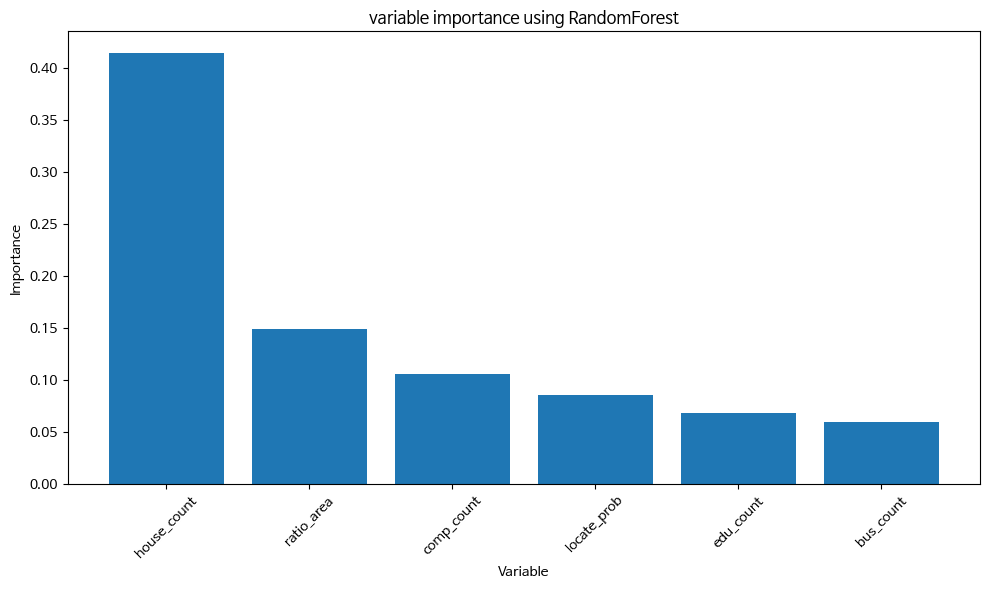

In [ ]:
# 오류 경고 무시하기
warnings.filterwarnings(action='ignore')

# 중요도를 내림차순으로 정렬
indices = np.argsort(importances)[::-1]

# 상위 n개 변수만 표시 (원하는 개수로 변경)
top_n = 6

plt.figure(figsize=(10, 6))
plt.title("variable importance using RandomForest")
plt.bar(range(top_n), importances[indices][:top_n], align="center")
plt.xticks(range(top_n), feature_names[indices][:top_n], rotation=45)
plt.xlabel("Variable")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# K-means 클러스터링

In [ ]:
# 대여소가 존재하지 않는 동의 데이터셋 생성
k_data = pd.merge(dataset, rent_count_df, how = 'left', on = 'adm_nm')
k_data = k_data[k_data['count'].isnull() == True].reset_index(drop=True)
k_data = k_data.drop('count', axis = 1);k_data

,sggnm,adm_nm,generation,population,comp_count,house_count,edu_count,lesp_count,bus_count,storage_count,car_counts,rate,locate_prob,ratio_area
0,완산구,중앙동,4949.0,10211.0,361,74,67,24,25,6,4,1.544176,0.257363,7854.615385
1,완산구,노송동,5802.0,11218.0,371,96,56,8,22,10,4,1.696461,0.169646,5393.269231
2,완산구,서서학동,4434.0,8424.0,74,114,25,2,20,1,1,1.273934,1.273934,2836.363636
3,완산구,중화산1동,6312.0,14110.0,90,175,87,9,11,5,1,2.133808,0.426762,10609.022556
4,완산구,중화산2동,9172.0,19528.0,678,416,245,61,21,0,3,2.953155,0.000000,12129.192547
5,완산구,평화1동,7122.0,12582.0,64,126,34,4,7,5,0,1.902734,0.380547,11335.135135
6,완산구,서신동,17427.0,40043.0,488,633,319,40,41,10,3,6.055570,0.605557,16684.583333
7,완산구,삼천1동,4973.0,11037.0,107,87,46,15,12,7,1,1.669089,0.238441,15767.142857
8,완산구,삼천2동,6254.0,13251.0,162,96,83,6,14,2,1,2.003905,1.001952,17906.756757
9,완산구,효자1동,5894.0,12995.0,86,151,57,10,6,4,0,1.965191,0.491298,12740.196078


## k값 정하기 - 엘보우 방법

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
X = k_data[['house_count','ratio_area']]

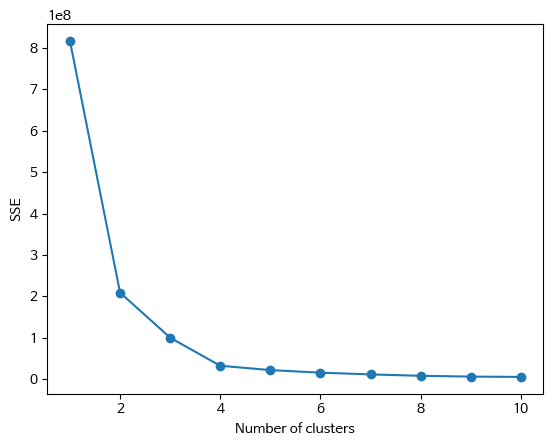

In [ ]:
# 엘보우 방법을 사용하여 최적의 K값 탐색
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# SSE 그래프 그리기
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

- k=4로 결정

## Scailing 및 clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

k = 4

# MinMaxScaler 선언 및 Fitting
mMscaler = MinMaxScaler()
mMscaled_data = mMscaler.fit_transform(X)

# 데이터 프레임으로 저장
mMscaled_data = pd.DataFrame(mMscaled_data)
mMscaled_data

,0,1
0,0.017959,0.392969
1,0.035918,0.261229
2,0.050612,0.124374
3,0.100408,0.540394
4,0.297143,0.621759
5,0.060408,0.579258
6,0.474286,0.865580
7,0.028571,0.816475
8,0.035918,0.930995
9,0.080816,0.654462


In [ ]:
# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 100, n_init = 10, max_iter = 100)

# 정규화된 데이터에 학습
model.fit(mMscaled_data)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
k_data['cluster'] = model.fit_predict(mMscaled_data)

## 클러스터링 결과 시각화

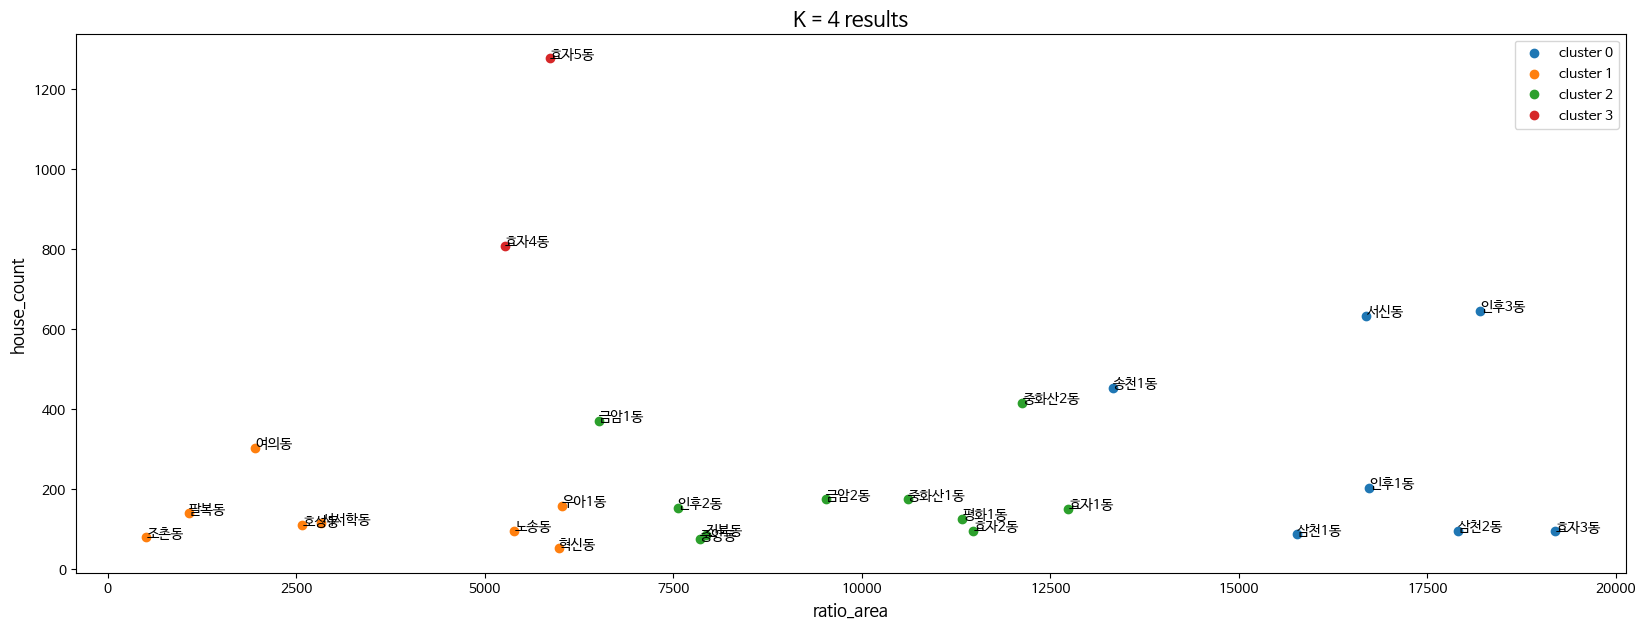

In [ ]:
plt.figure(figsize = (20, 7))

for i in range(k):
    plt.scatter(k_data.loc[k_data['cluster'] == i, 'ratio_area'], k_data.loc[k_data['cluster'] == i, 'house_count'],
                label = 'cluster ' + str(i))


plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('ratio_area', size = 12)
plt.ylabel('house_count', size = 12)


# 범례 달기
for row in k_data.itertuples():
    plt.annotate(row.adm_nm, (row.ratio_area, row.house_count))
plt.show()

cluster 0 중 인구비율도 높고 주택관련 개수도 많은 인후 3동과 서신동을 우선적으로 선정하였다. 또한 주택관련 개수가 많은 cluster3도 추가적으로 선정하였다.


# AHP 분석

In [ ]:
survey = pd.read_csv('/content/꽃싱이 수요조사.csv')
survey.columns = ['1','2','3','4','5','6','7','8','9','10']
survey = survey.drop(columns = ['1','2','3','10'], axis = 1);survey

,4,5,6,7,8,9
0,5,5,5,4,4,5
1,4,4,4,4,3,2
2,2,4,3,5,4,2
3,4,4,3,4,4,2
4,2,3,3,3,3,2
5,2,4,4,4,4,3
6,4,4,4,4,3,2
7,2,3,4,4,4,2
8,5,4,3,3,4,3
9,4,4,4,5,4,3


In [ ]:
# 주어진 데이터프레임
set1 = {
    '4': [5, 4, 2, 4, 2, 2, 4, 2, 5, 4, 4, 5, 4, 5, 4, 5, 2, 2, 3, 5, 2, 2, 4],
    '5': [5, 4, 4, 4, 3, 4, 4, 3, 4, 4, 3, 5, 4, 5, 2, 5, 3, 2, 3, 4, 3, 4, 4],
    '6': [5, 4, 3, 3, 3, 4, 4, 4, 3, 2, 2, 5, 4, 5, 4, 5, 2, 2, 2, 3, 2, 4, 3],
    '7': [4, 4, 5, 4, 3, 4, 4, 4, 3, 4, 4, 4, 3, 3, 5, 4, 4, 5, 5, 4, 4, 4, 4],
    '8': [4, 3, 4, 4, 3, 4, 3, 4, 4, 4, 4, 5, 3, 4, 3, 5, 3, 4, 4, 4, 3, 3, 3],
    '9': [5, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 5, 3, 4, 2, 5, 2, 2, 2, 2, 1, 1, 3]
}

survey = pd.DataFrame(set1)

# 숫자에 따라 값 변경
survey.replace({1: 1/3, 2: 1/2, 3: 1, 4: 2, 5: 3}, inplace=True)

print(survey)

      4    5    6  7  8         9
0   3.0  3.0  3.0  2  2  3.000000
1   2.0  2.0  2.0  2  1  0.500000
2   0.5  2.0  1.0  3  2  0.500000
3   2.0  2.0  1.0  2  2  0.500000
4   0.5  1.0  1.0  1  1  0.500000
5   0.5  2.0  2.0  2  2  1.000000
6   2.0  2.0  2.0  2  1  0.500000
7   0.5  1.0  2.0  2  2  0.500000
8   3.0  2.0  1.0  1  2  1.000000
9   2.0  2.0  0.5  2  2  1.000000
10  2.0  1.0  0.5  2  2  0.500000
11  3.0  3.0  3.0  2  3  3.000000
12  2.0  2.0  2.0  1  1  1.000000
13  3.0  3.0  3.0  1  2  2.000000
14  2.0  0.5  2.0  3  1  0.500000
15  3.0  3.0  3.0  2  3  3.000000
16  0.5  1.0  0.5  2  1  0.500000
17  0.5  0.5  0.5  3  2  0.500000
18  1.0  1.0  0.5  3  2  0.500000
19  3.0  2.0  1.0  2  2  0.500000
20  0.5  1.0  0.5  2  1  0.333333
21  0.5  2.0  2.0  2  1  0.333333
22  2.0  2.0  1.0  2  1  1.000000


In [ ]:
# 주어진 데이터프레임
set2 = pd.DataFrame({
    4: [3.0, 2.0, 0.5, 2.0, 0.5, 0.5, 2.0, 0.5, 3.0, 2.0, 2.0, 3.0, 2.0, 3.0, 2.0, 3.0, 0.5, 0.5, 1.0, 3.0, 0.5, 0.5, 1.0],
    5: [3.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0, 2.0, 3.0, 0.5, 3.0, 1.0, 0.5, 1.0, 2.0, 1.0, 2.0, 2.0],
    6: [3.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.5, 0.5, 3.0, 2.0, 3.0, 2.0, 3.0, 0.5, 0.5, 0.5, 1.0, 0.5, 2.0, 1.0],
    7: [2, 2, 3, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 3, 2, 2, 3, 3, 2, 2, 2, 2],
    8: [2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 3, 1, 2, 1, 3, 1, 2, 2, 2, 1, 1, 1],
    9: [3.0, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5, 3.0, 1.0, 2.0, 0.5, 3.0, 0.5, 0.5, 0.5, 0.5, 0.333333, 0.333333, 1.0]
})

# 각 행을 리스트로 추출
rows_as_lists = set2.values.tolist()

print(rows_as_lists)

[[3.0, 3.0, 3.0, 2.0, 2.0, 3.0], [2.0, 2.0, 2.0, 2.0, 1.0, 0.5], [0.5, 2.0, 1.0, 3.0, 2.0, 0.5], [2.0, 2.0, 1.0, 2.0, 2.0, 0.5], [0.5, 1.0, 1.0, 1.0, 1.0, 0.5], [0.5, 2.0, 2.0, 2.0, 2.0, 1.0], [2.0, 2.0, 2.0, 2.0, 1.0, 0.5], [0.5, 1.0, 2.0, 2.0, 2.0, 0.5], [3.0, 2.0, 1.0, 1.0, 2.0, 1.0], [2.0, 2.0, 0.5, 2.0, 2.0, 1.0], [2.0, 1.0, 0.5, 2.0, 2.0, 0.5], [3.0, 3.0, 3.0, 2.0, 3.0, 3.0], [2.0, 2.0, 2.0, 1.0, 1.0, 1.0], [3.0, 3.0, 3.0, 1.0, 2.0, 2.0], [2.0, 0.5, 2.0, 3.0, 1.0, 0.5], [3.0, 3.0, 3.0, 2.0, 3.0, 3.0], [0.5, 1.0, 0.5, 2.0, 1.0, 0.5], [0.5, 0.5, 0.5, 3.0, 2.0, 0.5], [1.0, 1.0, 0.5, 3.0, 2.0, 0.5], [3.0, 2.0, 1.0, 2.0, 2.0, 0.5], [0.5, 1.0, 0.5, 2.0, 1.0, 0.333333], [0.5, 2.0, 2.0, 2.0, 1.0, 0.333333], [1.0, 2.0, 1.0, 2.0, 1.0, 1.0]]


In [ ]:
weight_list = [] # 가중치를 담을 빈 리스트

# 주어진 값
for i in range(0,len(survey)-1):
  values = rows_as_lists[i]

  # 1차원 배열을 2차원 대칭 행렬로 변환
  n = int(np.sqrt(2 * len(values) + 0.25) - 0.5)
  symmetric_matrix = np.eye(n+1)

  k = 0
  for i in range(n+1):
      for j in range(i+1, n+1):
          if i == n:
              symmetric_matrix[i, j] = 1/values[k]
              symmetric_matrix[j, i] = values[k]
          else:
              symmetric_matrix[i, j] = values[k]
              symmetric_matrix[j, i] = 1/values[k]
          k += 1

  # 각 열을 기준에 대한 상대적 중요도로 정규화
  normalized_matrix = symmetric_matrix / symmetric_matrix.sum(axis=0)

  # 가중치 행렬 (최종 의사결정에 사용)
  weight_matrix = normalized_matrix.mean(axis=1)

  weight_list.append(weight_matrix)

weight_list

[array([0.47675439, 0.22616959, 0.18947368, 0.10760234]),
 array([0.39365079, 0.23253968, 0.14126984, 0.23253968]),
 array([0.22718254, 0.42311508, 0.12251984, 0.22718254]),
 array([0.33531746, 0.28670635, 0.13640873, 0.24156746]),
 array([0.20714286, 0.29285714, 0.20714286, 0.29285714]),
 array([0.27916667, 0.39166667, 0.16458333, 0.16458333]),
 array([0.39365079, 0.23253968, 0.14126984, 0.23253968]),
 array([0.23813131, 0.38535354, 0.16994949, 0.20656566]),
 array([0.37459893, 0.22486631, 0.18957219, 0.21096257]),
 array([0.29861111, 0.28819444, 0.15972222, 0.25347222]),
 array([0.25347222, 0.29861111, 0.15972222, 0.28819444]),
 array([0.47359347, 0.24733817, 0.18200242, 0.09706594]),
 array([0.4, 0.2, 0.2, 0.2]),
 array([0.49147727, 0.19507576, 0.19507576, 0.11837121]),
 array([0.3082265 , 0.25988248, 0.21047009, 0.22142094]),
 array([0.47359347, 0.24733817, 0.18200242, 0.09706594]),
 array([0.16666667, 0.33333333, 0.16666667, 0.33333333]),
 array([0.13976648, 0.41895604, 0.1768544 

In [ ]:
# 주어진 리스트
set3 = [
    np.array([0.47675439, 0.22616959, 0.18947368, 0.10760234]),
    np.array([0.39365079, 0.23253968, 0.14126984, 0.23253968]),
    np.array([0.22718254, 0.42311508, 0.12251984, 0.22718254]),
    np.array([0.33531746, 0.28670635, 0.13640873, 0.24156746]),
    np.array([0.20714286, 0.29285714, 0.20714286, 0.29285714]),
    np.array([0.27916667, 0.39166667, 0.16458333, 0.16458333]),
    np.array([0.39365079, 0.23253968, 0.14126984, 0.23253968]),
    np.array([0.23813131, 0.38535354, 0.16994949, 0.20656566]),
    np.array([0.37459893, 0.22486631, 0.18957219, 0.21096257]),
    np.array([0.29861111, 0.28819444, 0.15972222, 0.25347222]),
    np.array([0.25347222, 0.29861111, 0.15972222, 0.28819444]),
    np.array([0.47359347, 0.24733817, 0.18200242, 0.09706594]),
    np.array([0.4, 0.2, 0.2, 0.2]),
    np.array([0.49147727, 0.19507576, 0.19507576, 0.11837121]),
    np.array([0.3082265 , 0.25988248, 0.21047009, 0.22142094]),
    np.array([0.47359347, 0.24733817, 0.18200242, 0.09706594]),
    np.array([0.16666667, 0.33333333, 0.16666667, 0.33333333]),
    np.array([0.13976648, 0.41895604, 0.1768544 , 0.26442308]),
    np.array([0.20519958, 0.37037815, 0.14637605, 0.27804622]),
    np.array([0.36521942, 0.26195145, 0.13260971, 0.24021942]),
    np.array([0.16316526, 0.32633051, 0.14845934, 0.36204489]),
    np.array([0.28205127, 0.32852562, 0.12339741, 0.2660257 ])
]

# NumPy 배열로 변환
data_array = np.array(set3)

# 데이터프레임으로 변환
weight = pd.DataFrame(data_array, columns=['4', '5', '6', '7'])
weight

,4,5,6,7
0,0.476754,0.226170,0.189474,0.107602
1,0.393651,0.232540,0.141270,0.232540
2,0.227183,0.423115,0.122520,0.227183
3,0.335317,0.286706,0.136409,0.241567
4,0.207143,0.292857,0.207143,0.292857
5,0.279167,0.391667,0.164583,0.164583
6,0.393651,0.232540,0.141270,0.232540
7,0.238131,0.385354,0.169949,0.206566
8,0.374599,0.224866,0.189572,0.210963
9,0.298611,0.288194,0.159722,0.253472


In [ ]:
weight_means = weight.mean() # 평균 가중치
print(weight_means)

4    0.315756
5    0.294170
6    0.165707
7    0.224367
dtype: float64


In [ ]:
important = dataset[['sggnm', 'adm_nm', 'ratio_area', 'house_count', 'lesp_count', 'comp_count']] # 중요 변수

# k-means 클러스터링으로 뽑은 행정동에만 해당되는 행 추출
result = important['adm_nm'].isin(['서신동','인후3동','효자4동','효자5동'])
important = important[result==True];important

,sggnm,adm_nm,ratio_area,house_count,lesp_count,comp_count
10,완산구,서신동,16684.583333,633,40,488
17,완산구,효자4동,5267.612903,808,48,308
18,완산구,효자5동,5860.725552,1277,83,898
22,덕진구,인후3동,18197.687861,646,27,342


In [ ]:
# 입지선정지수 산출하여 열 추가
important['score'] = 0.3158 * important['ratio_area'] + 0.2942 * important['house_count'] + 0.1657 * important['lesp_count'] + 0.2244 * important['comp_count']
important.sort_values('score', ascending = False) # 상위 4개 행정동

,sggnm,adm_nm,ratio_area,house_count,lesp_count,comp_count,score
22,덕진구,인후3동,18197.687861,646,27,342,6018.101727
10,완산구,서신동,16684.583333,633,40,488,5571.355217
18,완산구,효자5동,5860.725552,1277,83,898,2441.774829
17,완산구,효자4동,5267.612903,808,48,308,1978.294555


AHP 분석결과 계산한 입지선정지수를 통해 인후3동이 가장 유력한 후보지로 뽑혔다. QGIS를 활용하여 인후3동 내에서 최종 입지를 선정한다.